# <font color="mediumpurple">Técnicas Computacionais de Apoio Ao Diagnóstico</font>

#### Informática Biomédica
#### Universidade Federal de Ciências da Saúde de Porto Alegre - UFCSPA  

**Autor:** Rafaela Laura Ribeiro

# Configuração de Ambiente e Paths

In [1]:
# Imports necessários
import os
import json
from collections import defaultdict

import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# Configuração geral
BASE_PATH = "/home/kolber/dev/rafa"

print("Rodando localmente")
print(f"Pasta base: {BASE_PATH}")

2025-11-25 01:02:33.641744: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 01:02:33.664218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-25 01:02:33.682507: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-25 01:02:33.687235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-25 01:02:33.707448: I tensorflow/core/platform/cpu_feature_guar

Rodando localmente
Pasta base: /home/kolber/dev/rafa


In [3]:
# Instalação de dependências e configuração de GPU
import sys
import subprocess
# Configuração da GPU
#Implementação para usar placa de vídeo para o treinamento do modelo
import tensorflow as tf

print("\n" + "="*60)
print("CONFIGURAÇÃO DA GPU")
print("="*60)

gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs disponíveis: {len(gpus)}")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print(f"GPU configurada com sucesso!")
        print(f"Modelo: {gpus[0].name}")
        
        print(f"TensorFlow build com CUDA: {tf.test.is_built_with_cuda()}")
        print(f"GPU disponível para TF: {tf.test.is_gpu_available(cuda_only=True)}")
        
    except RuntimeError as e:
        print(f"Erro ao configurar GPU: {e}")
else:
    print("Nenhuma GPU detectada. Usando CPU.")

print("="*60 + "\n")



CONFIGURAÇÃO DA GPU
GPUs disponíveis: 1
GPU configurada com sucesso!
Modelo: /physical_device:GPU:0
TensorFlow build com CUDA: True
GPU disponível para TF: True



I0000 00:00:1764043562.662867   67158 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764043562.662985   67158 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764043562.663019   67158 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764043562.663260   67158 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-25 01:06:02.663279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

In [3]:
# Pasta onde está localizado o dataset
DATASET_DIR = os.path.join(BASE_PATH, "dataset")

IMG_DIR           = os.path.join(DATASET_DIR, "images")
IMAGEWISE_CSV     = os.path.join(DATASET_DIR, "Imagewise_Data.csv")
PATIENTWISE_CSV   = os.path.join(DATASET_DIR, "Patientwise_Data.csv")
ANNOTATION_JSON   = os.path.join(DATASET_DIR, "Annotation.json")

print("DATASET_DIR:", DATASET_DIR)
print("Arquivos na pasta base:", os.listdir(DATASET_DIR))
print("Exemplos de imagens:", os.listdir(IMG_DIR)[:10])

DATASET_DIR: /home/kolber/dev/rafa/dataset
Arquivos na pasta base: ['Imagewise_Data.csv', 'Patientwise_Data.csv', 'images', 'Annotation.json']
Exemplos de imagens: ['N-066-01.jpg', 'R-227-05.jpg', 'R-09-01.jpg', 'N-271-03.jpg', 'R-08-02.jpg', 'N-274-06.jpg', 'R-91-04.jpg', 'R-57-02.jpg', 'N-085-02.jpg', 'N-238-02.jpg']


In [4]:
# Carregamento dos Metadados (CSV)
df_img = pd.read_csv(IMAGEWISE_CSV)
df_pat = pd.read_csv(PATIENTWISE_CSV)

print("Colunas de Imagewise_Data.csv:")
print(list(df_img.columns), "\n")
display(df_img.head())

print("\nColunas de Patientwise_Data.csv:")
print(list(df_pat.columns), "\n")
display(df_pat.head())


Colunas de Imagewise_Data.csv:
['Image Name', 'Category', 'Clinical Diagnosis', 'Lesion Annotation Count'] 



,Image Name,Category,Clinical Diagnosis,Lesion Annotation Count
0,R-01-01,OPMD,Leukoplakia,1
1,R-01-02,OPMD,Leukoplakia,1
2,R-01-03,Benign,Coated Tongue,1
3,R-02-01,Benign,VBD,1
4,R-02-02,Benign,VBD,1



Colunas de Patientwise_Data.csv:
['Patient ID', 'Age', 'Gender', 'Smoking', 'Chewing_Betel_Quid ', 'Alcohol', 'Image Count'] 



,Patient ID,Age,Gender,Smoking,Chewing_Betel_Quid,Alcohol,Image Count
0,R-01,63,M,No,No,No,3
1,R-02,17,F,No,No,No,8
2,R-03,70,M,No,No,No,5
3,R-04,45,M,No,No,No,5
4,R-05,46,M,No,Yes,No,2


# Análise do Dataset e Padronização dos DataFrames

In [5]:
# Padronizando os nomes das colunas - Renomear colunas para que se siga o padrão snake_case

# Dataframes que estão sendo padronizados:
# df_img: Contém informações das imagens (nome, categoria, diagnóstico)
# df_pat: Contém informações dos pacientes (idade, sexo, fatores de risco)
df_img = df_img.rename(columns={
    "Image Name": "image_name",
    "Category": "category",
    "Clinical Diagnosis": "clinical_diagnosis",
    "Lesion Annotation Count": "lesion_annotation_count"
})

# Remover espaços extras dos nomes das colunas
# Foi necessário essa etapa pois no arquivo CSV original, o nome da coluna tem um espaço em branco no final: "Chewing_Betel_Quid "
df_pat.columns = df_pat.columns.str.strip()

df_pat = df_pat.rename(columns={
    "Patient ID": "patient_id",
    "Age": "age",
    "Gender": "gender",
    "Smoking": "smoking",
    "Chewing_Betel_Quid": "chewing_betel_quid",
    "Alcohol": "alcohol",
    "Image Count": "image_count"
})

#Nomes das colunas após padronização
print("Colunas de df_img:", list(df_img.columns))
print("Colunas de df_pat:",  list(df_pat.columns))

Colunas de df_img: ['image_name', 'category', 'clinical_diagnosis', 'lesion_annotation_count']
Colunas de df_pat: ['patient_id', 'age', 'gender', 'smoking', 'chewing_betel_quid', 'alcohol', 'image_count']


In [6]:
# Extraindo patient_id a partir do nome da imagem
# Objetivo é juntar os dados de imagens com dados de pacientes, realizando um merge entre df_img e df_pat
df_img["patient_id"] = df_img["image_name"].apply(lambda x: x.split("-")[0] + "-" + x.split("-")[1]
)

df_img[["image_name", "patient_id"]].head()


,image_name,patient_id
0,R-01-01,R-01
1,R-01-02,R-01
2,R-01-03,R-01
3,R-02-01,R-02
4,R-02-02,R-02


In [7]:
# Criando coluna image_path e verificando existência dos arquivos
# Etapa necessária para evitar erros durante o carregamento das imagens e identificar problemas no dataset
df_img["image_path"] = df_img["image_name"].apply(lambda x: os.path.join(IMG_DIR, x + ".jpg")
    if not x.lower().endswith(".jpg")
    else os.path.join(IMG_DIR, x)
)

df_img["exists"] = df_img["image_path"].apply(os.path.exists)

print("Total de imagens no CSV:", len(df_img))
print("Arquivos encontrados na pasta:", df_img["exists"].sum())
print("Arquivos NÃO encontrados:", (~df_img["exists"]).sum())

df_img[~df_img["exists"]].head()

Total de imagens no CSV: 3000
Arquivos encontrados na pasta: 3000
Arquivos NÃO encontrados: 0


,image_name,category,clinical_diagnosis,lesion_annotation_count,patient_id,image_path,exists


## Integração dos Dados: Imagens e Informações Clínicas dos Pacientes

In [8]:
# Merge entre df_img (informações das imagens) e df_pat (dados clínicos dos pacientes) usando 'patient_id' como chave
df = df_img.merge(df_pat, on="patient_id", how="left")

print("Shape do DataFrame final:", df.shape)
display(df.head())

print("Imagens em df:", len(df))
print("Pacientes únicos em df:", df["patient_id"].nunique())

print("\nValores ausentes por coluna:")
print(df.isna().sum())

Shape do DataFrame final: (3000, 13)


,image_name,category,clinical_diagnosis,lesion_annotation_count,patient_id,image_path,exists,age,gender,smoking,chewing_betel_quid,alcohol,image_count
0,R-01-01,OPMD,Leukoplakia,1,R-01,/home/kolber/dev/rafa/dataset/images/R-01-01.jpg,True,63,M,No,No,No,3
1,R-01-02,OPMD,Leukoplakia,1,R-01,/home/kolber/dev/rafa/dataset/images/R-01-02.jpg,True,63,M,No,No,No,3
2,R-01-03,Benign,Coated Tongue,1,R-01,/home/kolber/dev/rafa/dataset/images/R-01-03.jpg,True,63,M,No,No,No,3
3,R-02-01,Benign,VBD,1,R-02,/home/kolber/dev/rafa/dataset/images/R-02-01.jpg,True,17,F,No,No,No,8
4,R-02-02,Benign,VBD,1,R-02,/home/kolber/dev/rafa/dataset/images/R-02-02.jpg,True,17,F,No,No,No,8


Imagens em df: 3000
Pacientes únicos em df: 714

Valores ausentes por coluna:
image_name                 0
category                   0
clinical_diagnosis         0
lesion_annotation_count    0
patient_id                 0
image_path                 0
exists                     0
age                        0
gender                     0
smoking                    0
chewing_betel_quid         0
alcohol                    0
image_count                0
dtype: int64


## Split do Dataset: Divisão Estratificada por Paciente (Train/Val/Test)

**A divisão é feita por paciente para evitar data leakage**

In [9]:
# Split estratificado por paciente para manter a proporção de classes
# Garantir que imagens do mesmo paciente não apareçam em conjuntos diferentes evitando data leakage
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

X = df.index.values
y = df["category"].values
groups = df["patient_id"].values

# Nível 1: Train+Val (80%) vs Test (20%)
gkf_outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
trainval_idx, test_idx = list(gkf_outer.split(X, y, groups))[0]

# Nível 2: Train (75%) vs Val (25%) dentro do Train+Val
df_trainval = df.loc[trainval_idx].copy()

gkf_inner = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=43)
train_idx_rel, val_idx_rel = list(
    gkf_inner.split(
        df_trainval.index.values,
        df_trainval["category"].values,
        df_trainval["patient_id"].values
    )
)[0]

train_idx = df_trainval.index.values[train_idx_rel]
val_idx   = df_trainval.index.values[val_idx_rel]

# Marcar splits no dataframe
df["split"] = "train"
df.loc[val_idx,  "split"] = "val"
df.loc[test_idx, "split"] = "test"

print(df["split"].value_counts())

split
train    1860
val       574
test      566
Name: count, dtype: int64


In [10]:
# Verificar data leakage entre os conjuntos
train_p = set(df[df["split"] == "train"]["patient_id"])
val_p   = set(df[df["split"] == "val"]["patient_id"])
test_p  = set(df[df["split"] == "test"]["patient_id"])

print("Train ∩ Val:", train_p & val_p)
print("Train ∩ Test:", train_p & test_p)
print("Val ∩ Test:", val_p & test_p)

Train ∩ Val: set()
Train ∩ Test: set()
Val ∩ Test: set()


In [11]:
# Distribuição de imagens por conjunto e categoria
table = (
    df.groupby(["split", "category"])
      .size()
      .unstack()
      .fillna(0)
      .astype(int)
)

table["Total"] = table.sum(axis=1)
table.loc["Total"] = table.sum(axis=0)

styled_table = (
    table.style
        .set_caption("Distribuição de Imagens por Split e Categoria")
        .background_gradient(cmap="Purples")
)

styled_table

category,Benign,Healthy,OCA,OPMD,Total
split,,,,,
test,158,152,22,234,566
train,463,441,79,877,1860
val,127,136,28,283,574
Total,748,729,129,1394,3000


## Processamento de Anotações: Extração de Regiões de Interesse (ROI)

**Carregamento das Anotações (COCO Format)**

In [12]:
# Carregamento do arquivo JSON com anotações das lesões e cavidade oral (COCO Format)
# Informações utilizadas para fazer crop das regiões de interesse (ROI)
with open(ANNOTATION_JSON, "r") as f:
    coco = json.load(f)

print("Chaves do JSON:", coco.keys())
print("Número de imagens no JSON:", len(coco["images"]))
print("Número de anotações:", len(coco["annotations"]))
print("Categorias no JSON:")
for cat in coco["categories"]:
    print(cat)

Chaves do JSON: dict_keys(['images', 'annotations', 'categories'])
Número de imagens no JSON: 3000
Número de anotações: 6358
Categorias no JSON:
{'id': 1, 'name': 'Lesion', 'supercategory': 'object'}
{'id': 2, 'name': 'Oral Cavity', 'supercategory': 'object'}


In [13]:
# ID da categoria "lesão" nas anotações COCO
LESION_CATEGORY_ID = 1

In [14]:
# Mapeamento entre ID numérico e nomes das imagens para vincular bounding boxes às imagens corretas
# Converte entre ID numérico (anotações COCO) e nome da imagem (R-01-01.jpg) usado no df
coco_id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}

image_name_to_coco_id = {
    os.path.splitext(fname)[0]: img_id
    for img_id, fname in coco_id_to_filename.items()
}

list(image_name_to_coco_id.items())[:5]

[('R-01-01', 1),
 ('R-01-02', 2),
 ('R-01-03', 3),
 ('R-02-01', 4),
 ('R-02-02', 5)]

In [15]:
 # Agrupa todas as bounding boxes de lesões por imagem
name_to_bboxes = defaultdict(list) 

for ann in coco["annotations"]:
    if ann["category_id"] == LESION_CATEGORY_ID:
        img_id = ann["image_id"]
        fname = coco_id_to_filename[img_id]              
        img_name = os.path.splitext(fname)[0]  
        name_to_bboxes[img_name].append(ann["bbox"])

print("Imagens com pelo menos 1 bbox de lesão:", len(name_to_bboxes))
example_key = next(iter(name_to_bboxes))
print("Exemplo:", example_key, "->", name_to_bboxes[example_key])


Imagens com pelo menos 1 bbox de lesão: 2271
Exemplo: R-01-01 -> [[2574, 1739, 464, 562]]


In [16]:
 # Mapear as bounding boxes (coordenadas das lesões) do COCO para o dataframe
 # Criar coluna lesion_bboxes (lista com coordenadas das lesões), has_lesion (se tem lesão ou não) e 
 # bbox_count (número de lesões por imagem)
df["lesion_bboxes"] = df["image_name"].map(name_to_bboxes)

df["lesion_bboxes"] = df["lesion_bboxes"].apply(
    lambda x: x if isinstance(x, list) else []
)

df["has_lesion"] = df["lesion_bboxes"].apply(lambda x: len(x) > 0)
df["bbox_count"] = df["lesion_bboxes"].apply(len)

display(
    df[["image_name", "category", "lesion_annotation_count",
        "bbox_count", "has_lesion"]].head()
)

,image_name,category,lesion_annotation_count,bbox_count,has_lesion
0,R-01-01,OPMD,1,1,True
1,R-01-02,OPMD,1,1,True
2,R-01-03,Benign,1,1,True
3,R-02-01,Benign,1,1,True
4,R-02-02,Benign,1,1,True


In [17]:
# Verificar a consistência entre contagens do JSON (bbox_count) e CSV (lesion_annotation_count)
mismatch = df[df["bbox_count"] != df["lesion_annotation_count"]][
    ["image_name", "category", "lesion_annotation_count", "bbox_count"]
]

print(f"Verificação de consistência: {len(mismatch)} imagens com diferença entre anotações JSON e CSV")

if len(mismatch) > 0:
    display(mismatch.head())
else:
    print("Todas as contagens estão consistentes entre CSV e JSON")

# Distribuição de imagens com e sem lesão por split
lesion_table = (
    df.groupby(["split", "has_lesion"])
      .size()
      .unstack()
      .fillna(0)
      .astype(int)
)
# Criar tabela mostrando quantas imagens têm/não têm lesão em cada conjunto                 
lesion_table.columns = ["Sem lesão", "Com lesão"]
lesion_table["Total"] = lesion_table.sum(axis=1)
lesion_table.loc["Total"] = lesion_table.sum(axis=0)

lesion_table.style.set_caption(
    "Distribuição de Lesões Anotadas por Conjunto"
).background_gradient(cmap="Purples")

Verificação de consistência: 1 imagens com diferença entre anotações JSON e CSV


,image_name,category,lesion_annotation_count,bbox_count
658,N-226-01,Benign,2,3


,Sem lesão,Com lesão,Total
split,,,
test,152,414,566
train,441,1419,1860
val,136,438,574
Total,729,2271,3000


## Visualização das Anotações

Visualização das bounding boxes de **Lesão** e **Cavidade Oral**

In [18]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Mapear ID numérico para nome da categoria ("Lesion", "Oral Cavity")
categories = {c["id"]: c["name"] for c in coco["categories"]}

color_map = {
    "Lesion": "lime",       
    "Oral Cavity": "cyan",  
}

# Função para visualizar imagem com suas bounding boxes anotadas
def show_image_with_boxes(image_name):

    # Obter ID numérico da imagem no formato COCO
    img_id = image_name_to_coco_id[image_name]      # você já criou name_to_id antes

    # Buscar metadados da imagem no JSON (nome do arquivo, dimensões)
    img_info = next(img for img in coco["images"] if img["id"] == img_id)
    image_filename = img_info["file_name"]   # ex: "R-01-01.jpg"

    # Obter caminho completo da imagem no dataframe
    image_path = df.loc[df["image_name"] == image_name, "image_path"].iloc[0]

    # Carregar imagem e converter BGR (OpenCV) para RGB (Matplotlib)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Filtrar apenas anotações desta imagem específica
    annotations_for_image = [
        ann for ann in coco["annotations"] if ann["image_id"] == img_id
    ]

    # Plotar a imagem
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img)

    # Desenhar bounding boxes sobre a imagem
    for ann in annotations_for_image:
        x, y, w, h = ann["bbox"]                  
        category = categories[ann["category_id"]] 
        color = color_map.get(category, "red")  

        # Criar retângulo da bounding box
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)

        # Adicionar label com nome da categoria acima da bbox
        ax.text(
            x,
            y - 5,
            category,
            color='white',
            fontsize=12,
            bbox=dict(facecolor=color, alpha=0.8)
        )

    plt.title(image_filename)
    plt.axis('off')
    plt.show()

Imagem: R-23-05


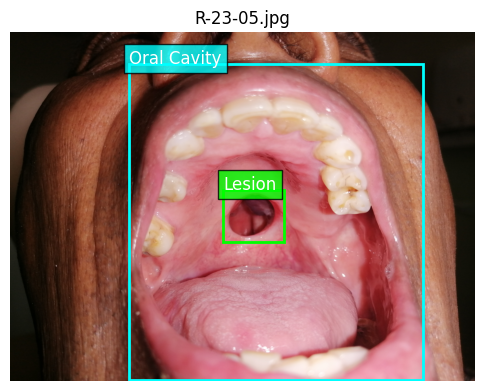

In [19]:
# Visualizar exemplo de imagem do conjunto de treino com bounding boxes anotadas
sample_names = (
    df[(df["split"] == "train") & (df["has_lesion"])]
    ["image_name"]
    .sample(1, random_state=42)
)

for name in sample_names:
    print("Imagem:", name)
    show_image_with_boxes(name)

# Pré-processamento de Imagens

Imagens **com** lesão: Crop da região da lesão (com padding)

Imagens **sem** lesão: Crop da cavidade oral ou imagem completa


In [20]:
# Validação dos caminhos do dataset - exibe diretórios e exemplos de arquivos
print("DATASET_DIR:", DATASET_DIR)
print("IMG_DIR:", IMG_DIR)
print("Arquivos na pasta base:", os.listdir(DATASET_DIR))
print("Exemplos de imagens:", os.listdir(IMG_DIR)[:10])


DATASET_DIR: /home/kolber/dev/rafa/dataset
IMG_DIR: /home/kolber/dev/rafa/dataset/images
Arquivos na pasta base: ['Imagewise_Data.csv', 'Patientwise_Data.csv', 'images', 'Annotation.json']
Exemplos de imagens: ['N-066-01.jpg', 'R-227-05.jpg', 'R-09-01.jpg', 'N-271-03.jpg', 'R-08-02.jpg', 'N-274-06.jpg', 'R-91-04.jpg', 'R-57-02.jpg', 'N-085-02.jpg', 'N-238-02.jpg']


In [21]:
# Criar estrutura de pastas para armazenar imagens processadas
CROP_BASE_DIR = os.path.join(BASE_PATH, "banco_oral_cancer_processed")

for split in ["train", "val", "test"]:
    for cat in ["Healthy", "Benign", "OPMD", "OCA"]:
        out_dir = os.path.join(CROP_BASE_DIR, split, cat)
        os.makedirs(out_dir, exist_ok=True)

print("Diretório base de imagens processadas:", CROP_BASE_DIR)
print("Subpastas criadas:", os.listdir(CROP_BASE_DIR))


Diretório base de imagens processadas: /home/kolber/dev/rafa/banco_oral_cancer_processed
Subpastas criadas: ['val', 'test', 'train']


In [22]:
# Conjunto de funções para carregar, recortar (crop) e processar as imagens usando as bounding boxes anotadas
import cv2
import numpy as np

def load_image_bgr(path):
    # Carregar imagem
    img = cv2.imread(path)
    if img is None:
        print("ERRO ao abrir imagem:", path)
    return img

def crop_from_bbox(img, bbox, padding=10):
    # Recortar região da imagem usando bbox com padding
    x, y, w, h = bbox
    H, W = img.shape[:2]
    # Calcular coordenadas com padding, garantindo que não ultrapassem os limites da imagem
    x1 = max(0, int(x - padding))
    y1 = max(0, int(y - padding))
    x2 = min(W, int(x + w + padding))
    y2 = min(H, int(y + h + padding))

    return img[y1:y2, x1:x2]

def choose_main_bbox(bboxes):
    # Seleciona a bbox de maior área quando há múltiplas lesões anotadas
    if not bboxes:
        return None
    return max(bboxes, key=lambda b: b[2] * b[3])


In [23]:
# Processamento e salvamento das imagens (crop de regiões de interesse)
# Coletar bounding boxes de cavidade oral
ORAL_CAVITY_CATEGORY_ID = 2  # Categoria "Oral Cavity"

name_to_oral_cavity_bboxes = defaultdict(list)
for ann in coco["annotations"]:
    if ann["category_id"] == ORAL_CAVITY_CATEGORY_ID:
        img_id = ann["image_id"]
        fname = coco_id_to_filename[img_id]
        img_name = os.path.splitext(fname)[0]
        name_to_oral_cavity_bboxes[img_name].append(ann["bbox"])

print(f"Imagens com anotação de cavidade oral: {len(name_to_oral_cavity_bboxes)}")

# Adicionar coluna com bboxes de cavidade oral ao dataframe
df["oral_cavity_bboxes"] = df["image_name"].map(name_to_oral_cavity_bboxes)
df["oral_cavity_bboxes"] = df["oral_cavity_bboxes"].apply(
    lambda x: x if isinstance(x, list) else []
)

# Agora processamos as imagens
saved_paths = []
num_saved = 0
num_with_lesion = 0
num_with_oral_cavity = 0
num_full_image = 0

for idx, row in df.iterrows():
    # Carregar imagem original
    img = load_image_bgr(row["image_path"])
    if img is None:
        saved_paths.append(None)
        continue

    if row["has_lesion"]:
        # Prioridade 1: Crop da região de lesão anotada
        main_bbox = choose_main_bbox(row["lesion_bboxes"])
        crop = crop_from_bbox(img, main_bbox, padding=10)
        num_with_lesion += 1
        # Fallback: se crop falhar, usar imagem completa
        if crop.size == 0:
            crop = img
    elif len(row["oral_cavity_bboxes"]) > 0:
        # Prioridade 2: Crop da região de cavidade oral
        main_bbox = choose_main_bbox(row["oral_cavity_bboxes"])
        crop = crop_from_bbox(img, main_bbox, padding=10)
        num_with_oral_cavity += 1
        # Fallback: se crop falhar, usar imagem completa
        if crop.size == 0:
            crop = img
    else:
        # Prioridade 3: Utilizar imagem completa (sem anotações disponíveis)
        crop = img
        num_full_image += 1
    # Definir caminho de saída
    out_path = os.path.join(
        CROP_BASE_DIR,
        row["split"],
        row["category"],
        row["image_name"] + ".jpg"
    )

    # Salvar imagem processada
    cv2.imwrite(out_path, crop)
    saved_paths.append(out_path)
    num_saved += 1
    # Feedback de progresso a cada 300 imagens
    if (idx + 1) % 300 == 0:
        print(f"{idx+1}/{len(df)} imagens processadas...")

# Estatísticas do processamento
print(f"\n{'='*70}")
print("Resumo do processamento de imagens")
print(f"{'='*70}")
print(f"Total de imagens processadas: {num_saved}")
print(f"Crop de lesão (prioridade 1):      {num_with_lesion} ({num_with_lesion/num_saved*100:.1f}%)")
print(f"Crop de cavidade oral (prioridade 2): {num_with_oral_cavity} ({num_with_oral_cavity/num_saved*100:.1f}%)")
print(f"Imagem completa (prioridade 3):    {num_full_image} ({num_full_image/num_saved*100:.1f}%)")
print(f"{'='*70}\n")

# Armazenar caminhos finais no dataframe para uso no treinamento
df["final_image_path"] = saved_paths


Imagens com anotação de cavidade oral: 2999
300/3000 imagens processadas...
600/3000 imagens processadas...
900/3000 imagens processadas...
1200/3000 imagens processadas...
1500/3000 imagens processadas...
1800/3000 imagens processadas...
2100/3000 imagens processadas...
2400/3000 imagens processadas...


Premature end of JPEG file


2700/3000 imagens processadas...
3000/3000 imagens processadas...

Resumo do processamento de imagens
Total de imagens processadas: 3000
Crop de lesão (prioridade 1):      2271 (75.7%)
Crop de cavidade oral (prioridade 2): 729 (24.3%)
Imagem completa (prioridade 3):    0 (0.0%)



#  Preparação do Dataset para Treinamento

**Carregamento e Redimensionamento das Imagens Processadas**

In [24]:
# Carregamento e preparação dos dados para treinamento
import os
import cv2
import numpy as np
from tqdm import tqdm

# Definições
categories  = ["Healthy", "Benign", "OPMD", "OCA"]
image_shape = (220, 220, 3)  # (altura, largura, canais)

# Caminhos dos diretórios organizados por split
train_dir = os.path.join(CROP_BASE_DIR, "train")
val_dir   = os.path.join(CROP_BASE_DIR, "val")
test_dir  = os.path.join(CROP_BASE_DIR, "test")

# Inicializar listas para armazenar dados
x_train_raw, y_train = [], []
x_val_raw,   y_val   = [], []
x_test_raw,  y_test  = [], []

# Carregar conjunto de treino
for dir_name in os.listdir(train_dir):
    if dir_name in categories:
        path = os.path.join(train_dir, dir_name)
        for image_name in tqdm(os.listdir(path), desc=f"Train - {dir_name}"):
            img_path = os.path.join(path, image_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (image_shape[1], image_shape[0]))
            x_train_raw.append(img)
            y_train.append(categories.index(dir_name))

# Carregar conjunto de validação
for dir_name in os.listdir(val_dir):
    if dir_name in categories:
        path = os.path.join(val_dir, dir_name)
        for image_name in tqdm(os.listdir(path), desc=f"Val - {dir_name}"):
            img_path = os.path.join(path, image_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (image_shape[1], image_shape[0]))
            x_val_raw.append(img)
            y_val.append(categories.index(dir_name))

# Carregar conjunto de teste
for dir_name in os.listdir(test_dir):
    if dir_name in categories:
        path = os.path.join(test_dir, dir_name)
        for image_name in tqdm(os.listdir(path), desc=f"Test - {dir_name}"):
            img_path = os.path.join(path, image_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (image_shape[1], image_shape[0]))
            x_test_raw.append(img)
            y_test.append(categories.index(dir_name))

# Converter listas para arrays NumPy
x_train_raw = np.array(x_train_raw, dtype="float32")
x_val_raw   = np.array(x_val_raw,   dtype="float32")
x_test_raw  = np.array(x_test_raw,  dtype="float32")

y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)

# Exibir dimensões dos conjuntos
print(f"x_train_raw shape: {x_train_raw.shape}, y_train shape: {y_train.shape}")
print(f"x_val_raw shape:   {x_val_raw.shape},   y_val shape:   {y_val.shape}")
print(f"x_test_raw shape:  {x_test_raw.shape},  y_test shape:  {y_test.shape}")

# Análise da distribuição de classes
print("\n" + "="*70)
print("Distribuição das classes por conjunto")
print("="*70)

from collections import Counter

train_dist = Counter(y_train)
val_dist = Counter(y_val)
test_dist = Counter(y_test)

print("\nConjunto de treino:")
for i, cat in enumerate(categories):
    count = train_dist[i]
    pct = (count / len(y_train)) * 100
    print(f"   {cat:12} (classe {i}): {count:4d} amostras ({pct:5.2f}%)")

print("\nConjunto de validação:")
for i, cat in enumerate(categories):
    count = val_dist[i]
    pct = (count / len(y_val)) * 100
    print(f"   {cat:12} (classe {i}): {count:4d} amostras ({pct:5.2f}%)")

print("\nConjunto de teste:")
for i, cat in enumerate(categories):
    count = test_dist[i]
    pct = (count / len(y_test)) * 100
    print(f"   {cat:12} (classe {i}): {count:4d} amostras ({pct:5.2f}%)")

print("="*70)

Test - Healthy: 100%|██████████| 152/152 [00:03<00:00, 50.45it/s]


x_train_raw shape: (1860, 220, 220, 3), y_train shape: (1860,)
x_val_raw shape:   (574, 220, 220, 3),   y_val shape:   (574,)
x_test_raw shape:  (566, 220, 220, 3),  y_test shape:  (566,)

Distribuição das classes por conjunto

Conjunto de treino:
   Healthy      (classe 0):  441 amostras (23.71%)
   Benign       (classe 1):  463 amostras (24.89%)
   OPMD         (classe 2):  877 amostras (47.15%)
   OCA          (classe 3):   79 amostras ( 4.25%)

Conjunto de validação:
   Healthy      (classe 0):  136 amostras (23.69%)
   Benign       (classe 1):  127 amostras (22.13%)
   OPMD         (classe 2):  283 amostras (49.30%)
   OCA          (classe 3):   28 amostras ( 4.88%)

Conjunto de teste:
   Healthy      (classe 0):  152 amostras (26.86%)
   Benign       (classe 1):  158 amostras (27.92%)
   OPMD         (classe 2):  234 amostras (41.34%)
   OCA          (classe 3):   22 amostras ( 3.89%)


In [25]:
# Conferir se os labels estão corretamente mapeados às categorias
print("\n" + "="*70)
print("VERIFICAÇÃO CRÍTICA: Mapeamento de Categorias")
print("="*70)

# Mostrar o mapeamento definido no código
print("\n1. Mapeamento definido no código:")
for i, cat in enumerate(categories):
    print(f"   {cat:12} → índice {i}")

# Verificar quantas imagens de cada pasta foram carregadas
print("\n2. Verificação: Arquivos nas pastas vs Labels nos arrays:")
print("-" * 70)
print(f"{'Categoria':<12} {'Arquivos Treino':<15} {'Labels Treino':<15} {'Status'}")
print("-" * 70)

for i, cat in enumerate(categories):
    train_path = os.path.join(train_dir, cat)
    if os.path.exists(train_path):
        num_files = len(os.listdir(train_path))
        num_labels = np.sum(y_train == i)
        match = "OK" if num_files == num_labels else "ERRO"
        print(f"{cat:<12} {num_files:<15} {num_labels:<15} {match}")

# Verificação cruzada: conferir se imagens foram salvas nas pastas corretas
print("\n3. Verificação cruzada com CSV original:")
print("-" * 70)

# Carregar o CSV novamente para conferir
df_check = pd.read_csv(IMAGEWISE_CSV)
df_check = df_check.rename(columns={"Image Name": "image_name", "Category": "category"})

# Para cada categoria, pegar uma imagem da pasta e verificar no CSV
for i, cat in enumerate(categories):
    train_path = os.path.join(train_dir, cat)
    if os.path.exists(train_path):
        files = os.listdir(train_path)
        if len(files) > 0:
            # Pegar primeira imagem como exemplo
            sample_file = files[0].replace('.jpg', '')
            # Buscar no CSV
            csv_row = df_check[df_check['image_name'] == sample_file]
            if not csv_row.empty:
                csv_category = csv_row.iloc[0]['category']
                match = "OK" if csv_category == cat else f"ERRO - CSV: {csv_category}"
                print(f"{cat:<12} | Exemplo: {sample_file:<15} | CSV: {csv_category:<10} | {match}")
            else:
                print(f"{cat:<12} | Exemplo: {sample_file:<15} | Não encontrado no CSV")

print("="*70)


VERIFICAÇÃO CRÍTICA: Mapeamento de Categorias

1. Mapeamento definido no código:
   Healthy      → índice 0
   Benign       → índice 1
   OPMD         → índice 2
   OCA          → índice 3

2. Verificação: Arquivos nas pastas vs Labels nos arrays:
----------------------------------------------------------------------
Categoria    Arquivos Treino Labels Treino   Status
----------------------------------------------------------------------
Healthy      441             441             OK
Benign       463             463             OK
OPMD         877             877             OK
OCA          79              79              OK

3. Verificação cruzada com CSV original:
----------------------------------------------------------------------
Healthy      | Exemplo: R-57-02         | CSV: Healthy    | OK
Benign       | Exemplo: N-066-01        | CSV: Benign     | OK
OPMD         | Exemplo: R-09-01         | CSV: OPMD       | OK
OCA          | Exemplo: S-68-01         | CSV: OCA        | OK


## Data Augmentation


In [26]:
# Configurar do Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation otimizado para reduzir ruído nas curvas de treinamento
train_datagen = ImageDataGenerator(
    rotation_range=10,           
    width_shift_range=0.1,      
    height_shift_range=0.1,      
    shear_range=0.05,            
    zoom_range=0.1,              
    horizontal_flip=True,        
    brightness_range=[0.9, 1.1], 
    fill_mode='nearest'          
)

# Validação e teste: sem augmentation, apenas normalização
val_test_datagen = ImageDataGenerator()

print("Data Augmentation configurado com parâmetros otimizados")

Data Augmentation configurado com parâmetros otimizados


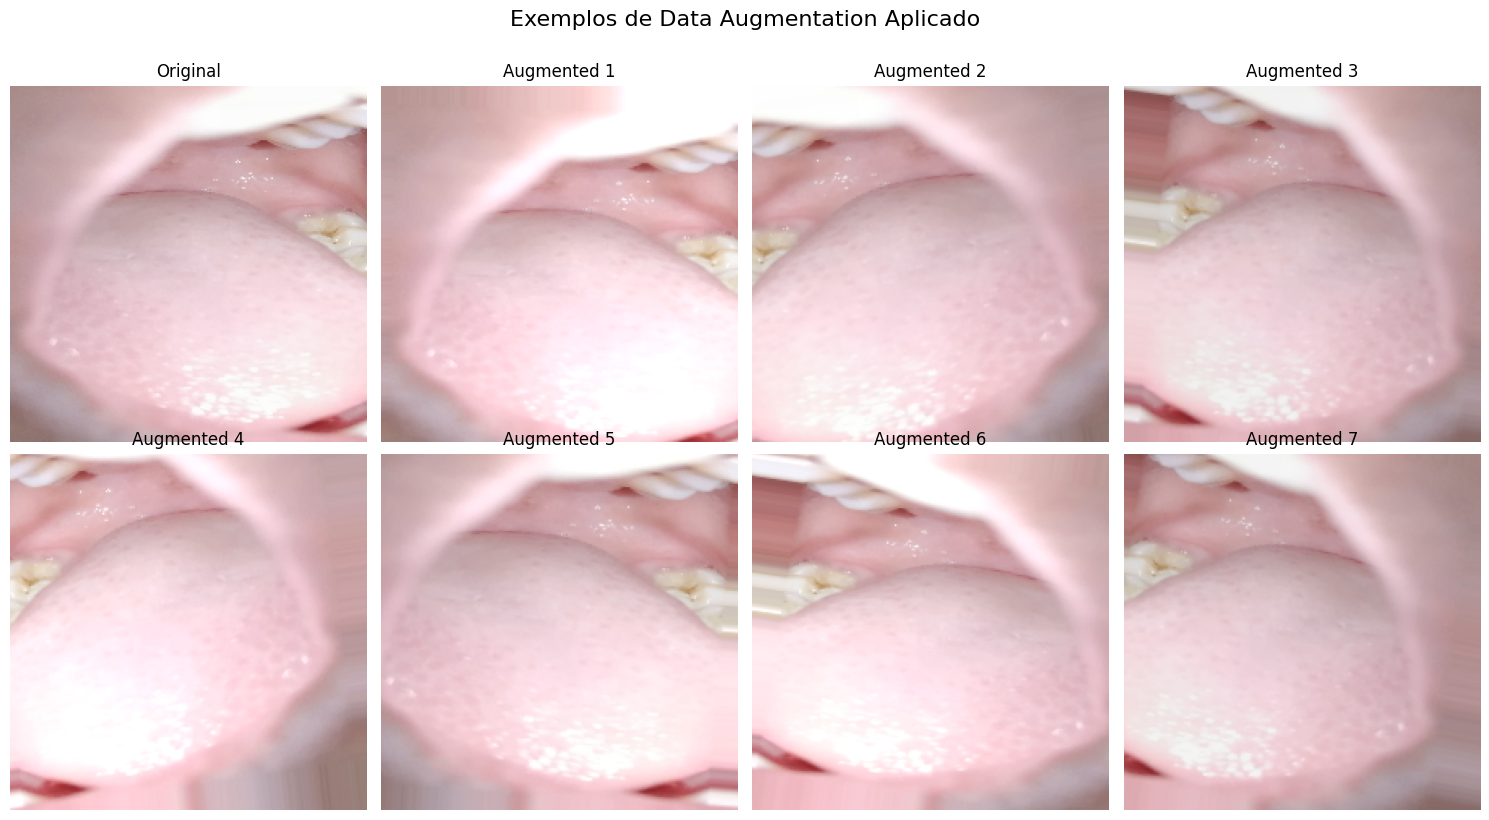

Visualização do Data Augmentation concluída


In [27]:
# Visualização de exemplos do Data Augmentation aplicado ao conjunto de treino
import matplotlib.pyplot as plt

# Selecionar uma imagem de exemplo
sample_img = x_train_raw[0:1].copy()

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Exemplos de Data Augmentation Aplicado', fontsize=16, y=1.02)

# Exibir imagem original
axes[0, 0].imshow(cv2.cvtColor(sample_img[0].astype('uint8'), cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Gerar e exibir 7 versões com augmentation
aug_gen = train_datagen.flow(sample_img, batch_size=1)
for i, ax in enumerate(axes.flatten()[1:]):
    aug_img = next(aug_gen)[0].astype('uint8')
    ax.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Augmented {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Visualização do Data Augmentation concluída")

## Visualização da Distribuição de Classes

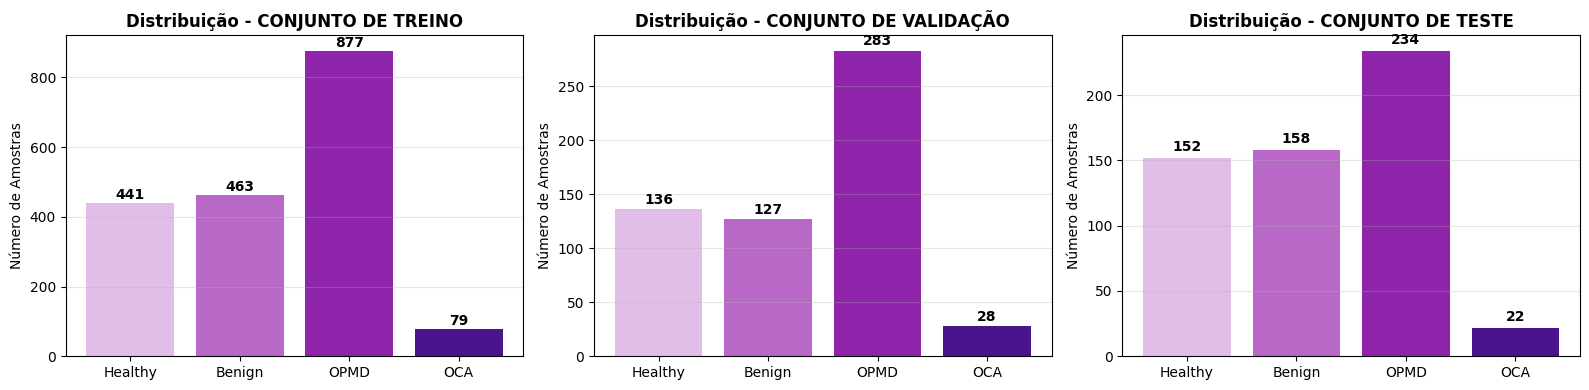


Observação: Classes desbalanceadas detectadas
A classe OCA possui significativamente menos amostras que as demais categorias.


In [28]:
# Visualização gráfica da distribuição de classes por conjunto
# Redefinir lista de categorias
categories = ["Healthy", "Benign", "OPMD", "OCA"]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Conjunto de treino
train_counts = [np.sum(y_train == i) for i in range(len(categories))]
axes[0].bar(categories, train_counts, color=['#E1BEE7', '#BA68C8', '#8E24AA', '#4A148C'])
axes[0].set_title('Distribuição - CONJUNTO DE TREINO', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Número de Amostras')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Conjunto de validação
val_counts = [np.sum(y_val == i) for i in range(len(categories))]
axes[1].bar(categories, val_counts, color=['#E1BEE7', '#BA68C8', '#8E24AA', '#4A148C'])
axes[1].set_title('Distribuição - CONJUNTO DE VALIDAÇÃO', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Número de Amostras')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(val_counts):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Conjunto de teste
test_counts = [np.sum(y_test == i) for i in range(len(categories))]
axes[2].bar(categories, test_counts, color=['#E1BEE7', '#BA68C8', '#8E24AA', '#4A148C'])
axes[2].set_title('Distribuição - CONJUNTO DE TESTE', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Número de Amostras')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_counts):
    axes[2].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nObservação: Classes desbalanceadas detectadas")
print("A classe OCA possui significativamente menos amostras que as demais categorias.")

## Balanceamento de Classes

Aplicação de pesos para compensar o desbalanceamento


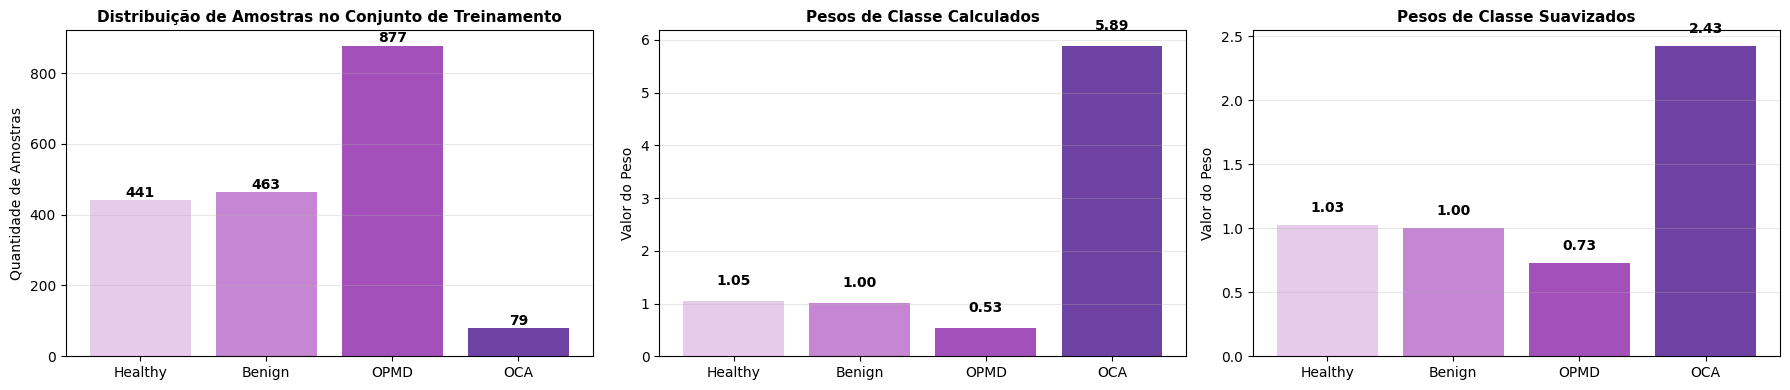

In [29]:
# Balanceamento de classes com suavização para reduzir impacto da classe minoritária (OCA)
categories = ["Healthy", "Benign", "OPMD", "OCA"] 
classes = np.arange(len(categories))
class_weights_vals = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights_suavizados = np.sqrt(class_weights_vals)

# Criar dicionário de pesos suavizados
class_weights = dict(zip(classes, class_weights_suavizados))

# Visualização gráfica dos pesos
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

# Gráfico 1: Distribuição de amostras no conjunto de treino
train_counts = [np.sum(y_train == i) for i in range(len(categories))]
ax1.bar(categories, train_counts, color=['#E1BEE7', '#BA68C8', '#8E24AA', '#4A148C'], alpha=0.8)
ax1.set_title('Distribuição de Amostras no Conjunto de Treinamento', fontsize=11, fontweight='bold')
ax1.set_ylabel('Quantidade de Amostras')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

# Gráfico 2: Pesos originais
weights_original = [class_weights_vals[i] for i in range(len(categories))]
ax2.bar(categories, weights_original, color=['#E1BEE7', '#BA68C8', '#8E24AA', '#4A148C'], alpha=0.8)
ax2.set_title('Pesos de Classe Calculados', fontsize=11, fontweight='bold')
ax2.set_ylabel('Valor do Peso')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(weights_original):
    ax2.text(i, v + 0.3, f'{v:.2f}', ha='center', fontweight='bold')

# Gráfico 3: Pesos suavizados
weights_suavizados = [class_weights[i] for i in range(len(categories))]
ax3.bar(categories, weights_suavizados, color=['#E1BEE7', '#BA68C8', '#8E24AA', '#4A148C'], alpha=0.8)
ax3.set_title('Pesos de Classe Suavizados', fontsize=11, fontweight='bold')
ax3.set_ylabel('Valor do Peso')
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(weights_suavizados):
    ax3.text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Treinamento - ResNet50

In [30]:
x_train_norm = resnet_preprocess(x_train_raw.copy())
x_val_norm   = resnet_preprocess(x_val_raw.copy())
x_test_norm  = resnet_preprocess(x_test_raw.copy())

In [31]:
# Configuração e construção do modelo ResNet50 com Transfer Learning
num_classes = len(categories)

# Carregar ResNet50 pré-treinada no ImageNet
base_resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling="avg",
)

# Congelar pesos da ResNet50 para treinamento inicial
base_resnet.trainable = False

# Construção da arquitetura completa
inputs = tf.keras.Input(shape=image_shape)
x = base_resnet(inputs, training=False)

# Camadas de classificação customizadas
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs, name="resnet50_oral_cancer")

# Compilação do modelo
model.compile(
    optimizer=Adam(learning_rate=2e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

# Configuração de callbacks
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    mode='max',
    verbose=1
)

# Preparação do gerador de dados com augmentation
train_gen = train_datagen.flow(
    x_train_norm,
    y_train,
    batch_size=64,
    shuffle=True
)

# Cálculo de steps per epoch
import math
steps_per_epoch = math.ceil(len(x_train_norm) / 64)

# Treinamento inicial
print("\n" + "="*70)
print("TREINAMENTO INICIAL - RESNET50")
print("="*70)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=(x_val_norm, y_val),
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(f"\nMelhor acurácia de validação: {max(history.history['val_accuracy']):.4f}")

# Armazenar melhor acurácia
best_val_acc_initial = max(history.history['val_accuracy'])

I0000 00:00:1764033588.940003    1994 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764033588.940138    1994 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764033588.940170    1994 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764033588.940552    1994 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-24 22:19:48.940574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

Model: "resnet50_oral_cancer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 220, 220, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,154,884 (92.14 MB)

 Trainable params: 562,564 (2.15 MB)

 Non-trainable params: 23,592,320 (90.00 MB)


TREINAMENTO INICIAL - RESNET50
Epoch 1/30


I0000 00:00:1764033596.923755   18425 service.cc:146] XLA service 0x7ccdb0013860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764033596.923794   18425 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-11-24 22:19:57.094287: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-24 22:19:58.131606: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/30 ━━━━━━━━━━━━━━━━━━━━ 5:17 11s/step - accuracy: 0.2500 - loss: 2.3183

I0000 00:00:1764033602.781547   18425 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 713ms/step - accuracy: 0.3833 - loss: 2.1004 - val_accuracy: 0.5958 - val_loss: 1.7676 - learning_rate: 2.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 384ms/step - accuracy: 0.5452 - loss: 1.7009 - val_accuracy: 0.6411 - val_loss: 1.5696 - learning_rate: 2.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.5828 - loss: 1.6035 - val_accuracy: 0.6742 - val_loss: 1.4924 - learning_rate: 2.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accuracy: 0.6091 - loss: 1.5500 - val_accuracy: 0.6847 - val_loss: 1.4397 - learning_rate: 2.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.6269 - loss: 1.4694 - val_accuracy: 0.6707 - val_loss: 1.4239 - learning_rate: 2.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.6473 - loss: 1.4481 - val_accuracy: 0.6847 - val_loss: 1.3952 - learning_rate: 2.0000e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.65

2025-11-24 22:25:13.261727: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 18585856 bytes after encountering the first element of size 18585856 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.7613 - loss: 1.1221 - val_accuracy: 0.7230 - val_loss: 1.3241 - learning_rate: 1.0000e-04
Epoch 28/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.7505 - loss: 1.1503 - val_accuracy: 0.7178 - val_loss: 1.3169 - learning_rate: 1.0000e-04
Epoch 29/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 375ms/step - accuracy: 0.7511 - loss: 1.1436 - val_accuracy: 0.7230 - val_loss: 1.3036 - learning_rate: 1.0000e-04
Epoch 30/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.7430 - loss: 1.1306 - val_accuracy: 0.7247 - val_loss: 1.3008 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.

Melhor acurácia de validação: 0.7247


## Fine-Tuning da Rede Neural


In [32]:
# Fine-tuning: descongelamento progressivo de camadas da ResNet50 para ajuste fino
print("\n" + "="*70)
print("FINE-TUNING - DESCONGELAMENTO DE CAMADAS SUPERIORES")
print("="*70)

# Análise da arquitetura
print(f"\nTotal de camadas no ResNet50: {len(base_resnet.layers)}")
print(f"Camadas atualmente treináveis: {sum([layer.trainable for layer in base_resnet.layers])}")

# Descongelar camadas superiores da ResNet50 para fine-tuning
base_resnet.trainable = True

# Congelar apenas os primeiros estágios (últimas 30 camadas treináveis)
for layer in base_resnet.layers[:-30]:
    layer.trainable = False

print(f"\nApós descongelamento:")
print(f"   Camadas treináveis: {sum([layer.trainable for layer in base_resnet.layers])}")
print(f"   Camadas congeladas: {len(base_resnet.layers) - sum([layer.trainable for layer in base_resnet.layers])}")

# Recompilar modelo com learning rate reduzido
model.compile(
    optimizer=Adam(learning_rate=5e-6),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print(f"\nConfiguração do fine-tuning:")
print(f"   Learning rate: 5e-6 (reduzido para ajuste fino)")
print(f"   Batch size: 64")
print(f"   Épocas máximas: 20")

# Callbacks para fine-tuning
early_stop_ft = EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr_ft = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    mode='max',
    verbose=1
)

# Preparar gerador de dados para fine-tuning
train_gen_ft = train_datagen.flow(
    x_train_norm,
    y_train,
    batch_size=64,
    shuffle=True
)

steps_per_epoch_ft = math.ceil(len(x_train_norm) / 64)

# Treinamento com fine-tuning
print("\n" + "="*70)
print("INICIANDO FINE-TUNING")
print("="*70 + "\n")

history_ft = model.fit(
    train_gen_ft,
    steps_per_epoch=steps_per_epoch_ft,
    validation_data=(x_val_norm, y_val),
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop_ft, reduce_lr_ft],
    verbose=1
)

print("\nFine-tuning concluído")

# Análise comparativa dos resultados
best_val_acc_ft = max(history_ft.history['val_accuracy'])
improvement = (best_val_acc_ft - best_val_acc_initial) * 100

print("\n" + "="*70)
print("COMPARAÇÃO: TREINAMENTO INICIAL VS FINE-TUNING")
print("="*70)
print(f"Acurácia inicial:      {best_val_acc_initial:.4f} ({best_val_acc_initial*100:.2f}%)")
print(f"Acurácia fine-tuning:  {best_val_acc_ft:.4f} ({best_val_acc_ft*100:.2f}%)")
if improvement > 0:
    print(f"Melhoria obtida:       +{improvement:.2f}%")
else:
    print(f"Variação:              {improvement:.2f}%")
print("="*70)

# Combinar históricos para visualização completa do treinamento
history_combined = {
    'accuracy': history.history['accuracy'] + history_ft.history['accuracy'],
    'loss': history.history['loss'] + history_ft.history['loss'],
    'val_accuracy': history.history['val_accuracy'] + history_ft.history['val_accuracy'],
    'val_loss': history.history['val_loss'] + history_ft.history['val_loss']
}


FINE-TUNING - DESCONGELAMENTO DE CAMADAS SUPERIORES

Total de camadas no ResNet50: 176
Camadas atualmente treináveis: 0

Após descongelamento:
   Camadas treináveis: 30
   Camadas congeladas: 146

Configuração do fine-tuning:
   Learning rate: 5e-6 (reduzido para ajuste fino)
   Batch size: 64
   Épocas máximas: 20

INICIANDO FINE-TUNING

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 664ms/step - accuracy: 0.7306 - loss: 1.1989 - val_accuracy: 0.7334 - val_loss: 1.2997 - learning_rate: 5.0000e-06
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.7392 - loss: 1.1748 - val_accuracy: 0.7300 - val_loss: 1.3099 - learning_rate: 5.0000e-06
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.7435 - loss: 1.1710 - val_accuracy: 0.7317 - val_loss: 1.3172 - learning_rate: 5.0000e-06
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.7366 - loss: 1.1642 - val_accuracy: 0.7334 - val_loss: 1.3211 - learning_rate: 5.0000e-06
Epoch 5/20
30/30 ━━━━━━━━━━━━━

2025-11-24 22:27:55.932634: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 18585856 bytes after encountering the first element of size 18585856 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.7473 - loss: 1.1482 - val_accuracy: 0.7334 - val_loss: 1.3317 - learning_rate: 5.0000e-06
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step - accuracy: 0.7441 - loss: 1.1646 - val_accuracy: 0.7282 - val_loss: 1.3306 - learning_rate: 2.5000e-06
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 381ms/step - accuracy: 0.7613 - loss: 1.1115 - val_accuracy: 0.7317 - val_loss: 1.3293 - learning_rate: 2.5000e-06
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.7629 - loss: 1.1231 - val_accuracy: 0.7300 - val_loss: 1.3287 - learning_rate: 2.5000e-06
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7529 - loss: 1.1608
Epoch 14: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.7672 - loss: 1.1245 - val_accuracy: 0.7352 - val_loss: 1.3308 - learning_rate: 2.5

# Resultados


**Curvas de Treinamento**



In [33]:
# Função para suavização de curvas usando Exponential Moving Average (EMA)
def smooth_curve(values, alpha=0.9):
    # Aplicar suavização exponencial para reduzir ruído nas curvas de treinamento
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = alpha * last + (1 - alpha) * v
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

print("Função de suavização definida (EMA)")

Função de suavização definida (EMA)


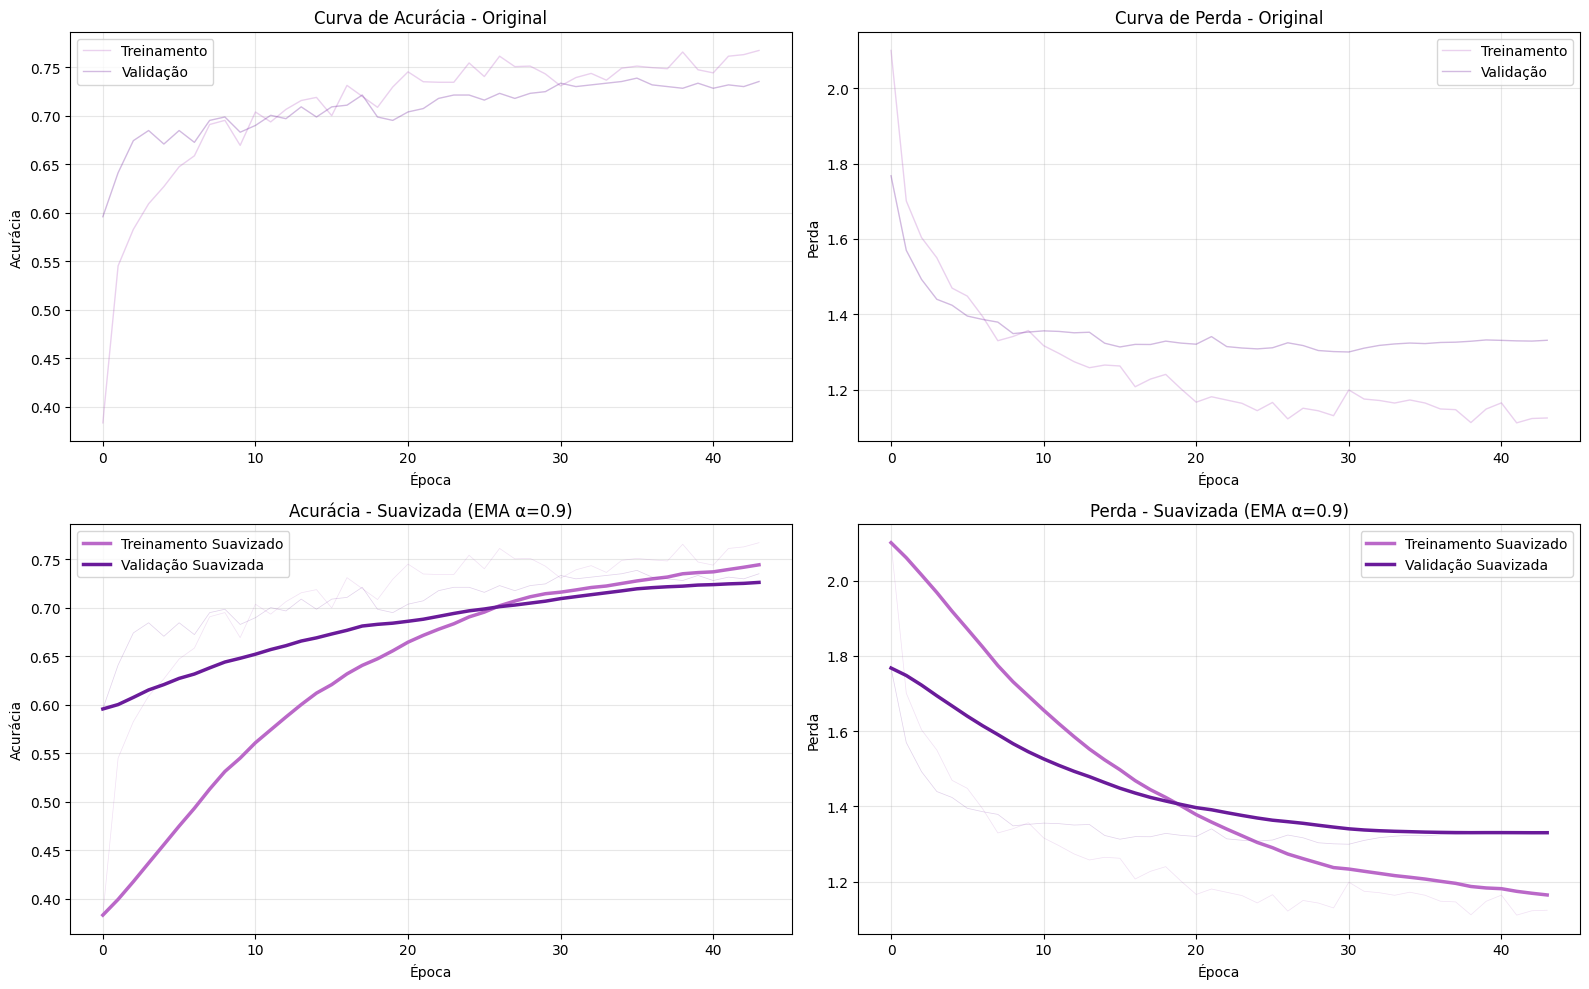


Análise das curvas de treinamento:
Compare os gráficos da linha 1 (originais) com linha 2 (suavizados)

Observações:
  - Gráficos suavizados facilitam identificação de tendências
  - Curvas originais mostram variabilidade natural do treinamento
  - Learning rate: 2e-4 inicial, 5e-6 fine-tuning


In [ ]:
# Visualização das curvas de treinamento: Accuracy e Loss (original e suavizado)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Gráficos originais (sem suavização)

# Accuracy original
axes[0, 0].plot(history_combined['accuracy'], color='#BA68C8', alpha=0.3, linewidth=1, label='Treinamento')
axes[0, 0].plot(history_combined['val_accuracy'], color='#6A1B9A', alpha=0.3, linewidth=1, label='Validação')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Acurácia')
axes[0, 0].set_title('Curva de Acurácia - Original')
axes[0, 0].grid(True, alpha=0.3)

# Loss original 
axes[0, 1].plot(history_combined['loss'], color='#BA68C8', alpha=0.3, linewidth=1, label='Treinamento')
axes[0, 1].plot(history_combined['val_loss'], color='#6A1B9A', alpha=0.3, linewidth=1, label='Validação')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Perda')
axes[0, 1].set_title('Curva de Perda - Original')
axes[0, 1].grid(True, alpha=0.3)

# Gráficos suavizados (com EMA)

# Accuracy suavizado
acc_smooth = smooth_curve(history_combined['accuracy'], alpha=0.9)
val_acc_smooth = smooth_curve(history_combined['val_accuracy'], alpha=0.9)
axes[1, 0].plot(history_combined['accuracy'], color='#BA68C8', alpha=0.2, linewidth=0.5)
axes[1, 0].plot(acc_smooth, color='#BA68C8', linewidth=2.5, label='Treinamento Suavizado')
axes[1, 0].plot(history_combined['val_accuracy'], color='#6A1B9A', alpha=0.2, linewidth=0.5)
axes[1, 0].plot(val_acc_smooth, color='#6A1B9A', linewidth=2.5, label='Validação Suavizada')
axes[1, 0].legend()
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Acurácia')
axes[1, 0].set_title('Acurácia - Suavizada (EMA α=0.9)')
axes[1, 0].grid(True, alpha=0.3)

# Loss suavizado
loss_smooth = smooth_curve(history_combined['loss'], alpha=0.9)
val_loss_smooth = smooth_curve(history_combined['val_loss'], alpha=0.9)
axes[1, 1].plot(history_combined['loss'], color='#BA68C8', alpha=0.2, linewidth=0.5)
axes[1, 1].plot(loss_smooth, color='#BA68C8', linewidth=2.5, label='Treinamento Suavizado')
axes[1, 1].plot(history_combined['val_loss'], color='#6A1B9A', alpha=0.2, linewidth=0.5)
axes[1, 1].plot(val_loss_smooth, color='#6A1B9A', linewidth=2.5, label='Validação Suavizada')
axes[1, 1].legend()
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Perda')
axes[1, 1].set_title('Perda - Suavizada (EMA α=0.9)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAnálise das curvas de treinamento:")
print("="*70)
print("Compare os gráficos da linha 1 (originais) com linha 2 (suavizados)")
print("\nObservações:")
print("  - Gráficos suavizados facilitam identificação de tendências")
print("  - Curvas originais mostram variabilidade natural do treinamento")
print("  - Learning rate: 2e-4 inicial, 5e-6 fine-tuning")
print("="*70)

## Avaliação no Conjunto de Teste


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step

Acurácia no conjunto de teste: 0.7597 (75.97%)


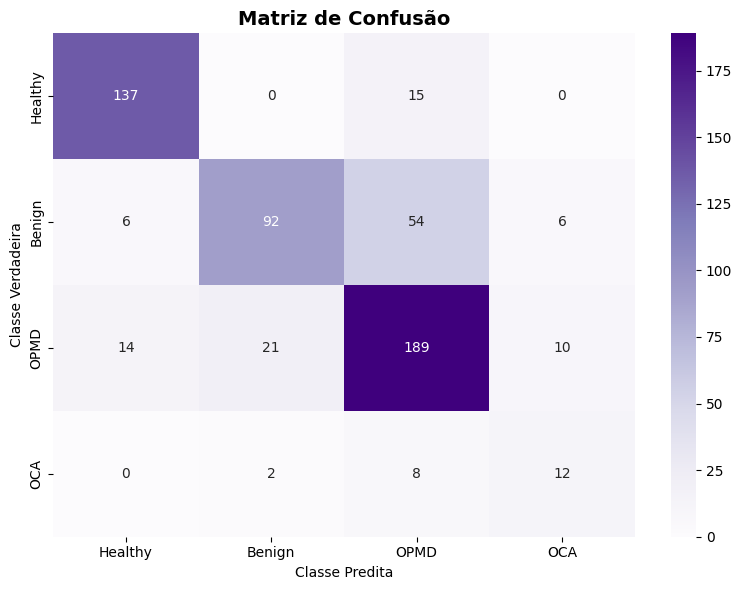


Relatório de Classificação:
              precision    recall  f1-score   support

     Healthy       0.87      0.90      0.89       152
      Benign       0.80      0.58      0.67       158
        OPMD       0.71      0.81      0.76       234
         OCA       0.43      0.55      0.48        22

    accuracy                           0.76       566
   macro avg       0.70      0.71      0.70       566
weighted avg       0.77      0.76      0.76       566



In [35]:
# Avaliação do modelo no conjunto de teste
# Realizar predições no conjunto de teste
y_pred_probs = model.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular acurácia final
test_accuracy = np.mean(y_pred == y_test)
print(f"\nAcurácia no conjunto de teste: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Calcular matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Visualização da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=categories, 
            yticklabels=categories,
            cbar=True)
plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Relatório detalhado de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=categories))

## Visualização Gráfico: Treinamento Inicial
 

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


/tmp/ipykernel_1994/2324648767.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


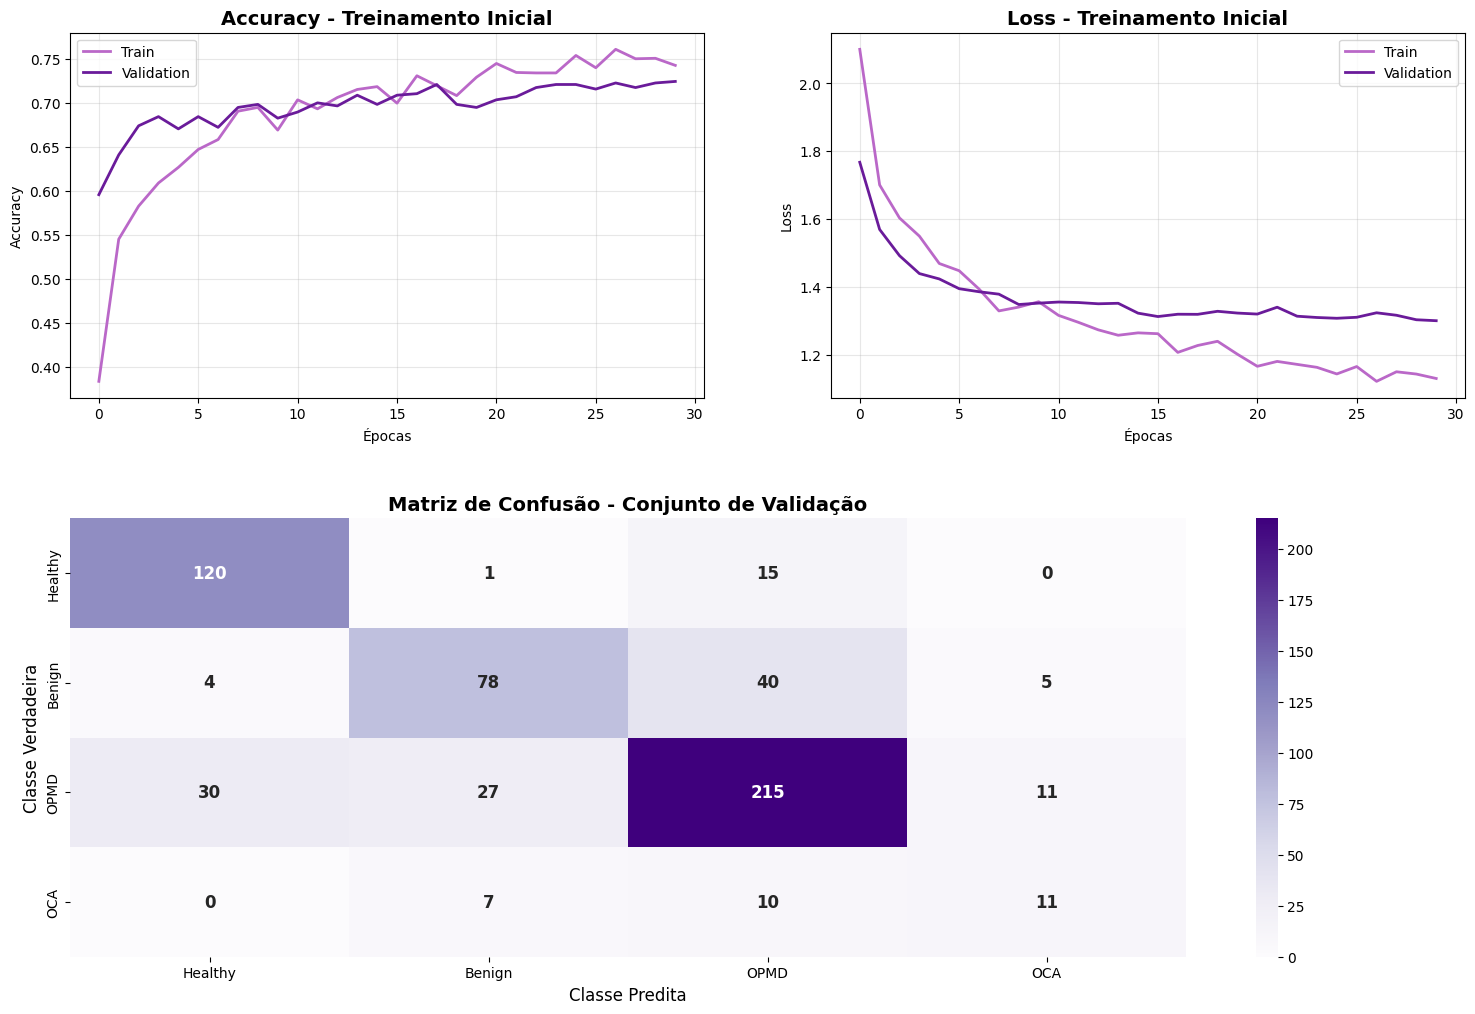


RESUMO DO TREINAMENTO INICIAL
Épocas realizadas: 30
Loss final (validação): 1.3008
Acurácia final (validação): 0.7247 (72.47%)


In [ ]:
# Visualização separada: Treinamento Inicial e Matriz de Confusão
# Verificar se as variáveis necessárias existem
try:
    history
except NameError:
    print("ERRO: Execute o treinamento inicial primeiro!")
    raise NameError("Variável 'history' não encontrada")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Criar figura com 3 subplots: 2 no topo (accuracy e loss) e 1 embaixo (matriz)
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2], hspace=0.3)

#  Acurácia
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(history.history['accuracy'], color='#BA68C8', linewidth=2, label='Train')
ax1.plot(history.history['val_accuracy'], color='#6A1B9A', linewidth=2, label='Validation')
ax1.set_title('Accuracy - Treinamento Inicial', fontsize=14, fontweight='bold')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history.history['loss'], color='#BA68C8', linewidth=2, label='Train')
ax2.plot(history.history['val_loss'], color='#6A1B9A', linewidth=2, label='Validation')
ax2.set_title('Loss - Treinamento Inicial', fontsize=14, fontweight='bold')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Matriz de Confusão no conjunto de validação
ax3 = fig.add_subplot(gs[1, :])

# Fazer predições no conjunto de validação
y_val_pred_probs = model.predict(x_val_norm)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Calcular matriz de confusão
cm_val = confusion_matrix(y_val, y_val_pred)

# Plotar matriz de confusão
categories = ["Healthy", "Benign", "OPMD", "OCA"]
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Purples', 
            xticklabels=categories, 
            yticklabels=categories,
            cbar=True, ax=ax3,
            annot_kws={"size": 12, "weight": "bold"})
ax3.set_title('Matriz de Confusão - Conjunto de Validação', fontsize=14, fontweight='bold')
ax3.set_ylabel('Classe Verdadeira', fontsize=12)
ax3.set_xlabel('Classe Predita', fontsize=12)

plt.tight_layout()
plt.show()

# Estatísticas do treinamento inicial
print("\n" + "="*70)
print("RESUMO DO TREINAMENTO INICIAL")
print("="*70)
print(f"Épocas realizadas: {len(history.history['loss'])}")
print(f"Loss final (validação): {history.history['val_loss'][-1]:.4f}")
print(f"Acurácia final (validação): {history.history['val_accuracy'][-1]:.4f} ({history.history['val_accuracy'][-1]*100:.2f}%)")
print("="*70)